In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    balanced_accuracy_score, average_precision_score, confusion_matrix,
    matthews_corrcoef, cohen_kappa_score, log_loss
)
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Load and prepare data
df = pd.read_csv('credit_risk_dataset.csv')
X = df.drop('loan_status', axis=1)
y = df['loan_status']

categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{y.value_counts()}")
print(f"Class ratio: {y.value_counts()[0]/y.value_counts()[1]:.2f}:1")


Dataset shape: (32581, 12)
Class distribution:
loan_status
0    25473
1     7108
Name: count, dtype: int64
Class ratio: 3.58:1


In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")


Training set: (26064, 11)
Test set: (6517, 11)
Training class distribution: [20378  5686]
Test class distribution: [5095 1422]


In [5]:
# Create CatBoost pools
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

# Train model with exact same parameters as .py file
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    class_weights={0: 1, 1: 12},
    nan_mode='Min',
    cat_features=categorical_features,
    l2_leaf_reg=3,
    task_type='CPU',
    thread_count=-1,
    eval_metric='AUC',
    verbose=100,
    random_seed=42
)

# Fit with early stopping and evaluation set
catboost_model.fit(
    train_pool,
    eval_set=test_pool,
    plot=False,
    use_best_model=True,
    early_stopping_rounds=50
)

print("✅ CatBoost training completed!")


0:	test: 0.8512279	best: 0.8512279 (0)	total: 180ms	remaining: 2m 59s
100:	test: 0.9309051	best: 0.9309051 (100)	total: 3.75s	remaining: 33.4s
200:	test: 0.9439002	best: 0.9439002 (200)	total: 7.72s	remaining: 30.7s
300:	test: 0.9493266	best: 0.9493389 (299)	total: 11.9s	remaining: 27.6s
400:	test: 0.9500758	best: 0.9503001 (394)	total: 18.3s	remaining: 27.3s
500:	test: 0.9509919	best: 0.9510829 (470)	total: 24.5s	remaining: 24.4s
600:	test: 0.9519037	best: 0.9519984 (596)	total: 30.8s	remaining: 20.4s
700:	test: 0.9522613	best: 0.9523047 (684)	total: 37s	remaining: 15.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9525606997
bestIteration = 746

Shrink model to first 747 iterations.
✅ CatBoost training completed!


In [6]:
# Get probabilities
y_prob = catboost_model.predict_proba(X_test)[:, 1]

# Threshold optimization with EXACT SAME LOGIC as .py file
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5]
best_threshold = 0.5
best_f1 = 0
best_recall = 0

print("Threshold Optimization:")

for threshold in thresholds:
    y_pred_thresh = (y_prob > threshold).astype(int)
    recall_thresh = recall_score(y_test, y_pred_thresh)
    precision_thresh = precision_score(y_test, y_pred_thresh)
    f1_thresh = f1_score(y_test, y_pred_thresh)
    
    # EXACT SAME THRESHOLD SELECTION LOGIC AS .py FILE:
    if recall_thresh >= 0.85 and f1_thresh > best_f1:
        best_threshold = threshold
        best_f1 = f1_thresh
        best_recall = recall_thresh
    elif recall_thresh > best_recall:
        best_threshold = threshold
        best_f1 = f1_thresh
        best_recall = recall_thresh

print(f"\n Optimal threshold selected: {best_threshold}")


Threshold Optimization:

 Optimal threshold selected: 0.5


In [7]:
# Use optimized threshold for final predictions
y_pred_optimized = (y_prob > best_threshold).astype(int)
print(f"✅ Using optimized predictions with threshold = {best_threshold}")

# Calculate comprehensive metrics (same as .py file)
def calculate_comprehensive_metrics(y_true, y_pred, y_prob):
    """Calculate all performance metrics exactly as .py file"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Additional metrics
    specificity = tn / (tn + fp)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    # Advanced metrics
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    # AUC metrics
    roc_auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    
    # Log loss
    logloss = log_loss(y_true, y_prob)
    
    # Gini coefficient
    gini = 2 * roc_auc - 1
    
    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1_score': f1,
        'npv': npv,
        'fpr': fpr,
        'fnr': fnr,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'mcc': mcc,
        'kappa': kappa,
        'gini': gini,
        'log_loss': logloss,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    }

# Calculate final metrics
metrics = calculate_comprehensive_metrics(y_test, y_pred_optimized, y_prob)


✅ Using optimized predictions with threshold = 0.5


In [8]:
print("Optimized Model - Comprehensive Performance Metrics:")
print("-" * 55)
print(f"{'Metric':<25} {'Value':<10} {'Description'}")
print("-" * 55)
print(f"{'Accuracy':<25} {metrics['accuracy']:<10.4f} Overall correctness")
print(f"{'Balanced Accuracy':<25} {metrics['balanced_accuracy']:<10.4f} Avg of sensitivity & specificity")
print(f"{'Precision (PPV)':<25} {metrics['precision']:<10.4f} TP / (TP + FP)")
print(f"{'Recall (Sensitivity)':<25} {metrics['recall']:<10.4f} TP / (TP + FN)")
print(f"{'Specificity (TNR)':<25} {metrics['specificity']:<10.4f} TN / (TN + FP)")
print(f"{'F1-Score':<25} {metrics['f1_score']:<10.4f} Harmonic mean of precision & recall")
print(f"{'NPV':<25} {metrics['npv']:<10.4f} TN / (TN + FN)")
print(f"{'False Positive Rate':<25} {metrics['fpr']:<10.4f} FP / (FP + TN)")
print(f"{'False Negative Rate':<25} {metrics['fnr']:<10.4f} FN / (FN + TP)")
print(f"{'ROC-AUC':<25} {metrics['roc_auc']:<10.4f} Area under ROC curve")
print(f"{'PR-AUC':<25} {metrics['pr_auc']:<10.4f} Area under PR curve")
print(f"{'Matthews Corr Coef':<25} {metrics['mcc']:<10.4f} Correlation coefficient")
print(f"{'Cohen Kappa':<25} {metrics['kappa']:<10.4f} Agreement correcting for chance")
print(f"{'Gini Coefficient':<25} {metrics['gini']:<10.4f} 2*AUC - 1")
print(f"{'Log Loss':<25} {metrics['log_loss']:<10.4f} Logarithmic loss (lower better)")


Optimized Model - Comprehensive Performance Metrics:
-------------------------------------------------------
Metric                    Value      Description
-------------------------------------------------------
Accuracy                  0.8499     Overall correctness
Balanced Accuracy         0.8655     Avg of sensitivity & specificity
Precision (PPV)           0.6059     TP / (TP + FP)
Recall (Sensitivity)      0.8931     TP / (TP + FN)
Specificity (TNR)         0.8379     TN / (TN + FP)
F1-Score                  0.7220     Harmonic mean of precision & recall
NPV                       0.9656     TN / (TN + FN)
False Positive Rate       0.1621     FP / (FP + TN)
False Negative Rate       0.1069     FN / (FN + TP)
ROC-AUC                   0.9526     Area under ROC curve
PR-AUC                    0.9097     Area under PR curve
Matthews Corr Coef        0.6464     Correlation coefficient
Cohen Kappa               0.6243     Agreement correcting for chance
Gini Coefficient          0.9

In [17]:

print("\n" + "="*60)
print("🔍 GENERATING SHAP EXPLAINABILITY ANALYSIS")
print("="*60)

# Initialize SHAP TreeExplainer for CatBoost
explainer = shap.TreeExplainer(catboost_model)

# Calculate SHAP values for test set (use sample for speed if dataset is large)
sample_size = min(30000, len(X_test))  # Use up to 1000 samples for speed
X_test_sample = X_test.sample(n=sample_size, random_state=42)
y_test_sample = y_test.loc[X_test_sample.index]

print(f"Calculating SHAP values for {sample_size} test samples...")
shap_values = explainer.shap_values(X_test_sample)

# Note: CatBoost returns SHAP values for both classes, we want class 1 (default)
if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]  # Class 1 (default/bad loans)
else:
    shap_values_class1 = shap_values

print("✅ SHAP values calculated!")



🔍 GENERATING SHAP EXPLAINABILITY ANALYSIS
Calculating SHAP values for 6517 test samples...
✅ SHAP values calculated!



📊 Generating SHAP visualizations...


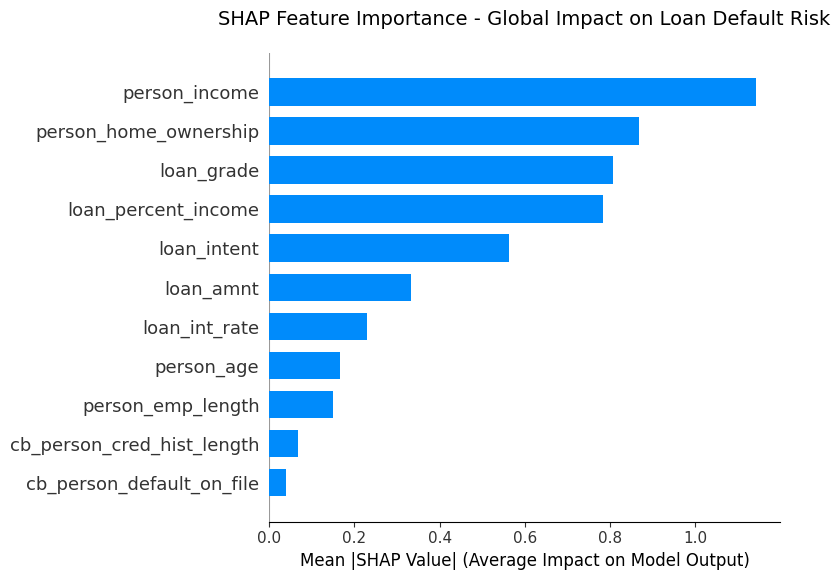

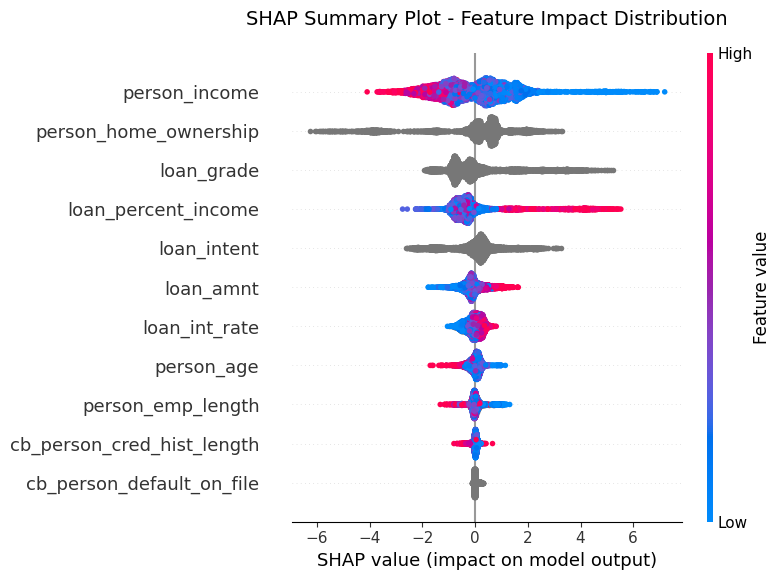


📈 Analyzing top feature impacts...
Top 6 features for analysis: ['person_income', 'person_home_ownership', 'loan_grade', 'loan_percent_income', 'loan_intent', 'loan_amnt']


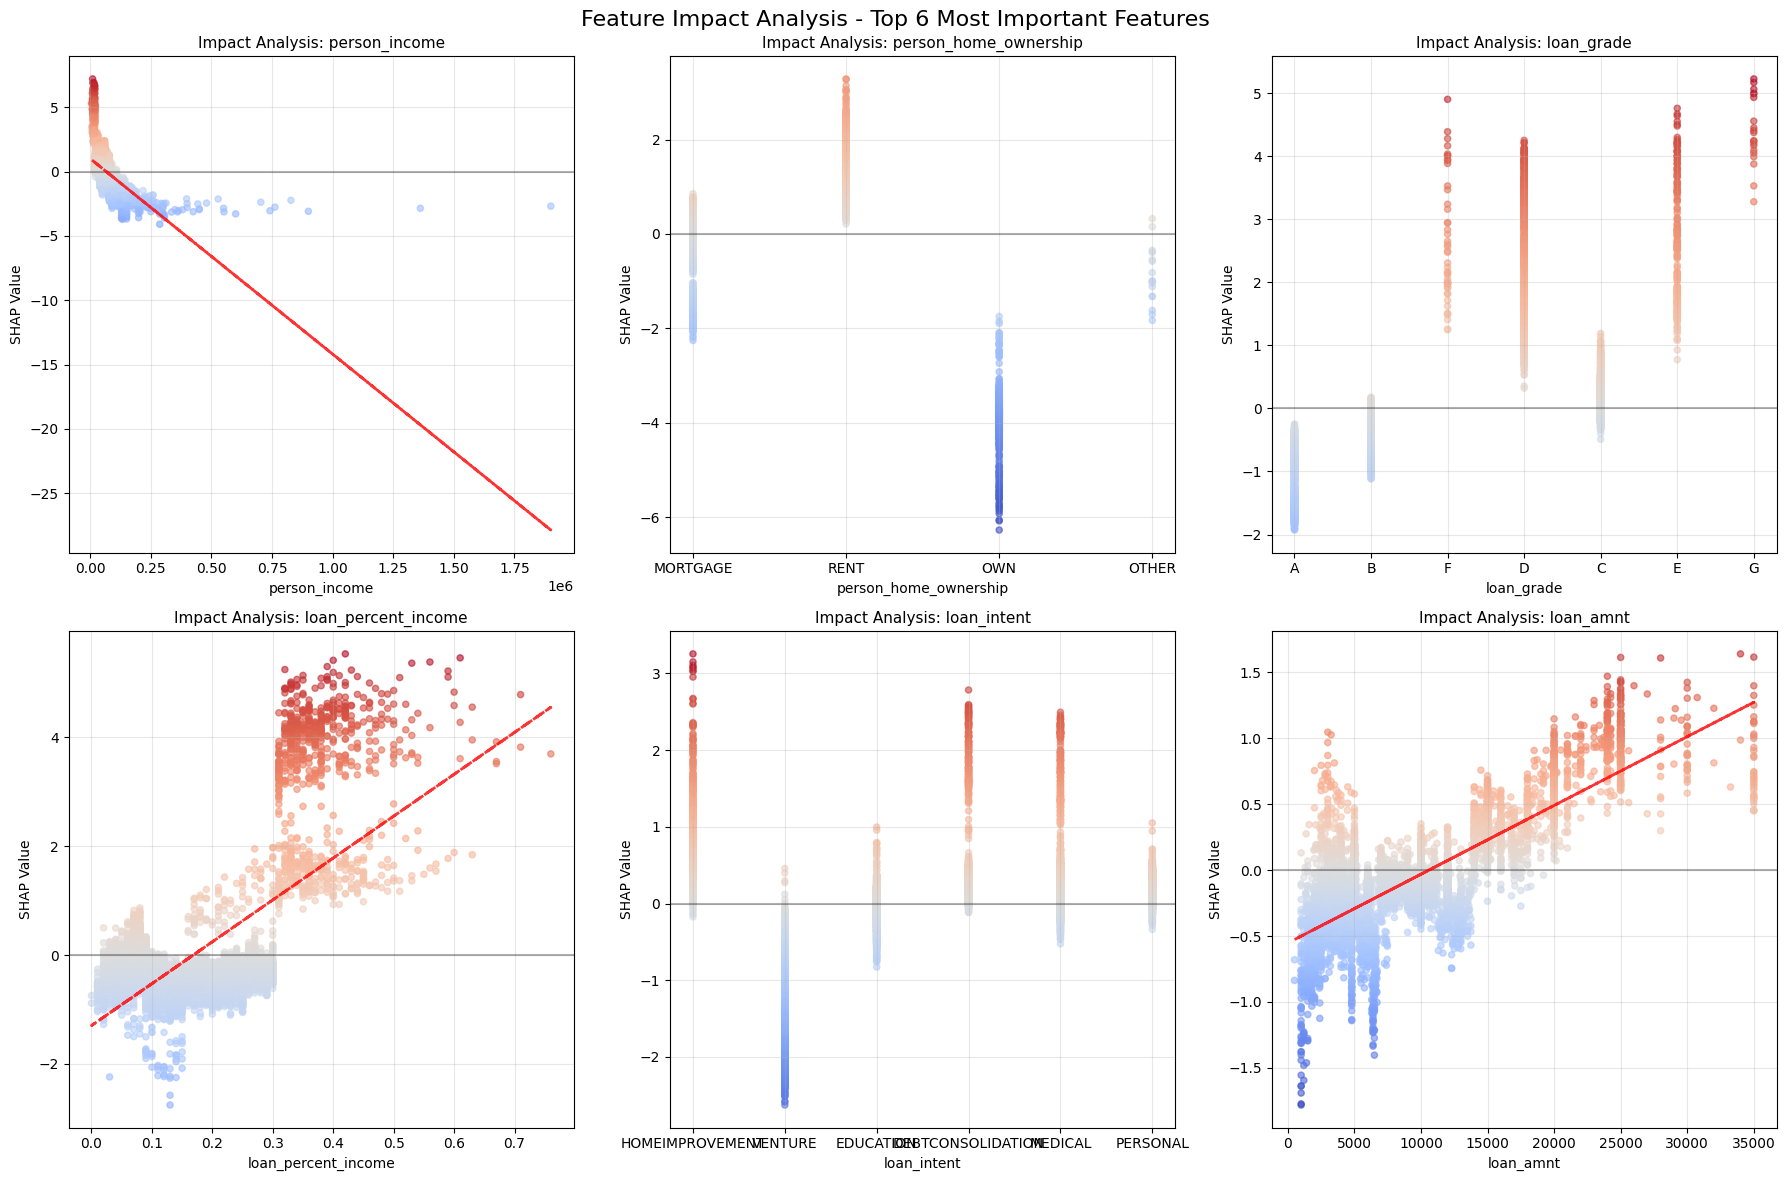


🔍 Analyzing individual predictions...


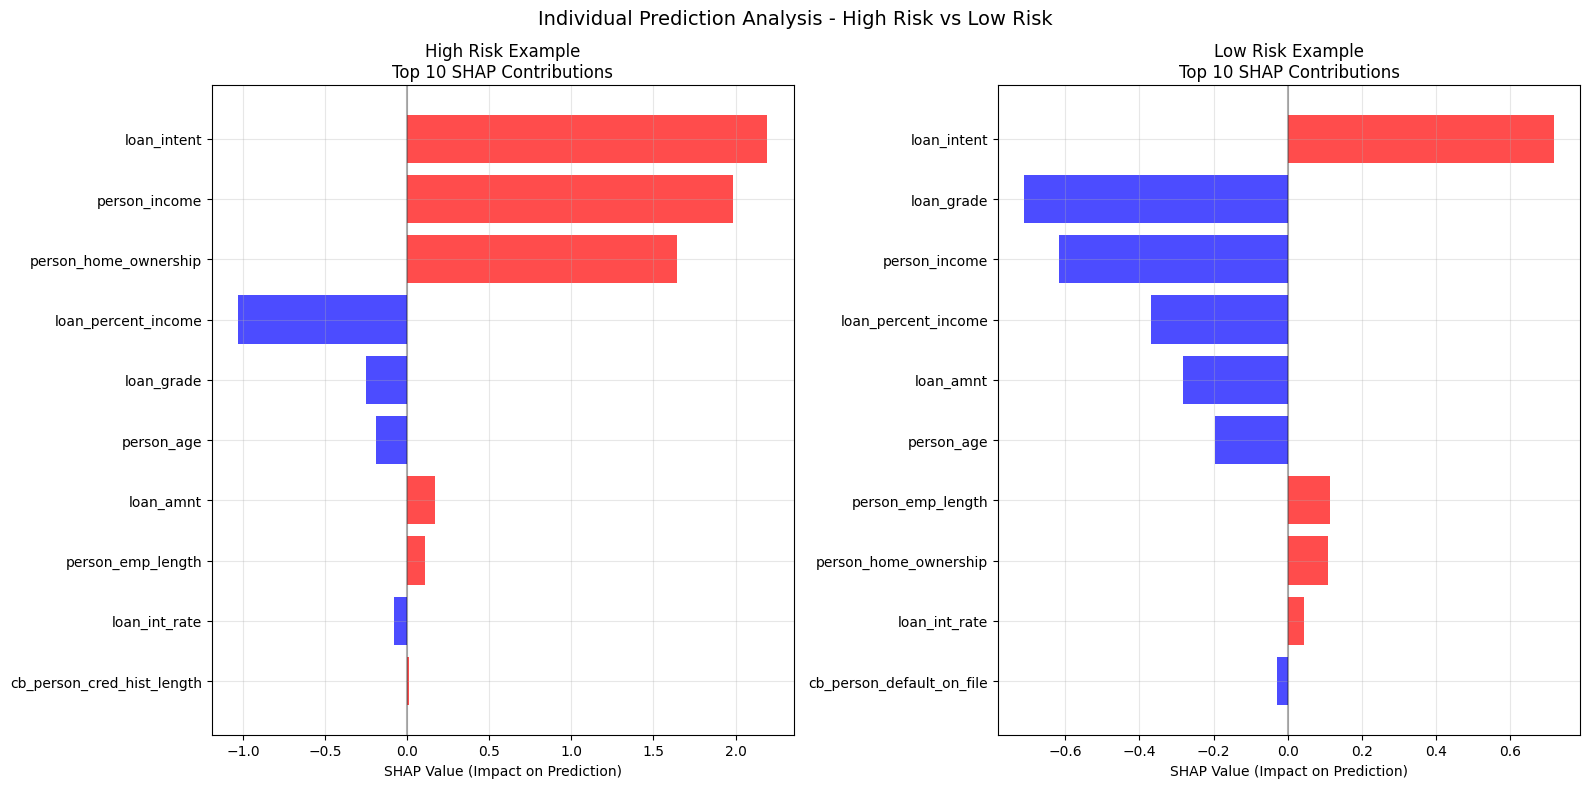


📊 HIGH RISK EXAMPLE ANALYSIS:
   Actual: Default
   Top positive contributors (increase risk):
     • cb_person_cred_hist_length: 4 (SHAP: +0.008)
     • person_emp_length: nan (SHAP: +0.111)
     • loan_amnt: 3500 (SHAP: +0.172)

   Top negative contributors (decrease risk):
     • loan_int_rate: 10.99 (SHAP: -0.081)
     • person_age: 25 (SHAP: -0.193)

📊 LOW RISK EXAMPLE ANALYSIS:
   Actual: No Default
   Top negative contributors (decrease risk):
     • cb_person_default_on_file: N (SHAP: -0.029)
     • person_age: 25 (SHAP: -0.195)
     • loan_amnt: 2000 (SHAP: -0.281)

   Top positive contributors (increase risk):
     • loan_int_rate: 7.66 (SHAP: +0.044)
     • person_home_ownership: MORTGAGE (SHAP: +0.108)

🔗 FEATURE INTERACTION INSIGHTS:
--------------------------------------------------
Top 5 most impactful features:
1. person_income: 1.1414 average |SHAP| impact
2. person_home_ownership: 0.8684 average |SHAP| impact
3. loan_grade: 0.8068 average |SHAP| impact
4. loan_percen

In [18]:
# ================================
# 📊 SHAP VISUALIZATIONS (FIXED)
# ================================

plt.style.use('default')
fig_size = (12, 8)

# 1. Feature Importance (Global)
print("\n📊 Generating SHAP visualizations...")

plt.figure(figsize=fig_size)
shap.summary_plot(shap_values_class1, X_test_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Global Impact on Loan Default Risk", fontsize=14, pad=20)
plt.xlabel("Mean |SHAP Value| (Average Impact on Model Output)", fontsize=12)
plt.tight_layout()
plt.savefig('shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Summary Plot (Feature Impact Distribution)
plt.figure(figsize=fig_size)
shap.summary_plot(shap_values_class1, X_test_sample, show=False)
plt.title("SHAP Summary Plot - Feature Impact Distribution", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. IMPROVED: Feature Impact Analysis (Skip Problematic Partial Dependence)
print("\n📈 Analyzing top feature impacts...")

# Get top 6 most important features
feature_importance = np.abs(shap_values_class1).mean(0)
top_features_idx = np.argsort(feature_importance)[-6:]
top_features = [X_test_sample.columns[i] for i in top_features_idx[::-1]]  # Reverse for descending order

print(f"Top 6 features for analysis: {top_features}")

# Create feature impact analysis instead of partial dependence
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(top_features):
    # Get SHAP values for this feature
    feature_idx = X_test_sample.columns.get_loc(feature)
    feature_shap_values = shap_values_class1[:, feature_idx]
    feature_values = X_test_sample.iloc[:, feature_idx]
    
    # Create scatter plot of feature value vs SHAP value
    axes[i].scatter(feature_values, feature_shap_values, alpha=0.6, s=20, 
                   c=feature_shap_values, cmap='coolwarm', vmin=-np.max(np.abs(feature_shap_values)), 
                   vmax=np.max(np.abs(feature_shap_values)))
    
    axes[i].set_xlabel(f'{feature}', fontsize=10)
    axes[i].set_ylabel('SHAP Value', fontsize=10)
    axes[i].set_title(f'Impact Analysis: {feature}', fontsize=11)
    axes[i].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[i].grid(True, alpha=0.3)
    
    # Add trend line for continuous features
    if X_test_sample[feature].dtype in ['int64', 'float64']:
        try:
            z = np.polyfit(feature_values, feature_shap_values, 1)
            p = np.poly1d(z)
            axes[i].plot(feature_values, p(feature_values), "r--", alpha=0.8, linewidth=2)
        except:
            pass

plt.suptitle('Feature Impact Analysis - Top 6 Most Important Features', fontsize=16)
plt.tight_layout()
plt.savefig('shap_feature_impact_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Individual Feature Analysis (Alternative to Waterfall)
print("\n🔍 Analyzing individual predictions...")

# Get top features and their contributions for high/low risk examples
high_risk_indices = X_test_sample.index[y_test_sample == 1]
low_risk_indices = X_test_sample.index[y_test_sample == 0]

if len(high_risk_indices) > 0 and len(low_risk_indices) > 0:
    # High risk example
    high_risk_idx = high_risk_indices[0]
    high_sample_idx = X_test_sample.index.get_loc(high_risk_idx)
    
    # Low risk example
    low_risk_idx = low_risk_indices[0]
    low_sample_idx = X_test_sample.index.get_loc(low_risk_idx)
    
    # Get SHAP values for these examples
    high_shap = shap_values_class1[high_sample_idx]
    low_shap = shap_values_class1[low_sample_idx]
    
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # High risk features
    high_shap_df = pd.DataFrame({
        'Feature': X_test_sample.columns,
        'SHAP_Value': high_shap
    }).sort_values('SHAP_Value', key=abs, ascending=True).tail(10)
    
    colors_high = ['red' if x > 0 else 'blue' for x in high_shap_df['SHAP_Value']]
    ax1.barh(range(len(high_shap_df)), high_shap_df['SHAP_Value'], color=colors_high, alpha=0.7)
    ax1.set_yticks(range(len(high_shap_df)))
    ax1.set_yticklabels(high_shap_df['Feature'], fontsize=10)
    ax1.set_title('High Risk Example\nTop 10 SHAP Contributions', fontsize=12)
    ax1.set_xlabel('SHAP Value (Impact on Prediction)')
    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax1.grid(True, alpha=0.3)
    
    # Low risk features
    low_shap_df = pd.DataFrame({
        'Feature': X_test_sample.columns,
        'SHAP_Value': low_shap
    }).sort_values('SHAP_Value', key=abs, ascending=True).tail(10)
    
    colors_low = ['red' if x > 0 else 'blue' for x in low_shap_df['SHAP_Value']]
    ax2.barh(range(len(low_shap_df)), low_shap_df['SHAP_Value'], color=colors_low, alpha=0.7)
    ax2.set_yticks(range(len(low_shap_df)))
    ax2.set_yticklabels(low_shap_df['Feature'], fontsize=10)
    ax2.set_title('Low Risk Example\nTop 10 SHAP Contributions', fontsize=12)
    ax2.set_xlabel('SHAP Value (Impact on Prediction)')
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Individual Prediction Analysis - High Risk vs Low Risk', fontsize=14)
    plt.tight_layout()
    plt.savefig('shap_individual_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed analysis
    print(f"\n📊 HIGH RISK EXAMPLE ANALYSIS:")
    print(f"   Actual: {'Default' if y_test_sample.loc[high_risk_idx] else 'No Default'}")
    print(f"   Top positive contributors (increase risk):")
    for _, row in high_shap_df[high_shap_df['SHAP_Value'] > 0].head(3).iterrows():
        feature_value = X_test_sample.loc[high_risk_idx, row['Feature']]
        print(f"     • {row['Feature']}: {feature_value} (SHAP: +{row['SHAP_Value']:.3f})")
    
    print(f"\n   Top negative contributors (decrease risk):")
    for _, row in high_shap_df[high_shap_df['SHAP_Value'] < 0].head(2).iterrows():
        feature_value = X_test_sample.loc[high_risk_idx, row['Feature']]
        print(f"     • {row['Feature']}: {feature_value} (SHAP: {row['SHAP_Value']:.3f})")
    
    print(f"\n📊 LOW RISK EXAMPLE ANALYSIS:")
    print(f"   Actual: {'Default' if y_test_sample.loc[low_risk_idx] else 'No Default'}")
    print(f"   Top negative contributors (decrease risk):")
    for _, row in low_shap_df[low_shap_df['SHAP_Value'] < 0].head(3).iterrows():
        feature_value = X_test_sample.loc[low_risk_idx, row['Feature']]
        print(f"     • {row['Feature']}: {feature_value} (SHAP: {row['SHAP_Value']:.3f})")
    
    print(f"\n   Top positive contributors (increase risk):")
    for _, row in low_shap_df[low_shap_df['SHAP_Value'] > 0].head(2).iterrows():
        feature_value = X_test_sample.loc[low_risk_idx, row['Feature']]
        print(f"     • {row['Feature']}: {feature_value} (SHAP: +{row['SHAP_Value']:.3f})")

# 5. Feature Interaction Analysis
print(f"\n🔗 FEATURE INTERACTION INSIGHTS:")
print("-" * 50)

# Calculate feature interactions from SHAP values
feature_names = X_test_sample.columns
feature_importance = np.abs(shap_values_class1).mean(0)

# Get most important features for interaction analysis
top_5_features = [feature_names[i] for i in np.argsort(feature_importance)[-5:][::-1]]

print(f"Top 5 most impactful features:")
for i, feature in enumerate(top_5_features, 1):
    avg_impact = feature_importance[feature_names.get_loc(feature)]
    print(f"{i}. {feature}: {avg_impact:.4f} average |SHAP| impact")

# Analyze correlation between top features and their SHAP values
correlation_analysis = []
for feature in top_5_features:
    feature_idx = feature_names.get_loc(feature)
    feature_values = X_test_sample.iloc[:, feature_idx]
    feature_shap = shap_values_class1[:, feature_idx]
    
    if feature_values.dtype in ['int64', 'float64']:
        correlation = np.corrcoef(feature_values, feature_shap)[0, 1]
        correlation_analysis.append((feature, correlation))

if correlation_analysis:
    print(f"\nFeature-SHAP correlations (for numerical features):")
    for feature, corr in sorted(correlation_analysis, key=lambda x: abs(x[1]), reverse=True):
        direction = "📈 Positive" if corr > 0 else "📉 Negative"
        print(f"  • {feature}: {direction} correlation ({corr:.3f})")

print("✅ SHAP visualizations completed!")

# Summary of files created
print(f"\n📁 FILES CREATED:")
print(f"   📊 shap_feature_importance.png - Global feature importance")
print(f"   📊 shap_summary_plot.png - Feature impact distribution")
print(f"   📊 shap_feature_impact_analysis.png - Top 6 feature impact analysis")
print(f"   📊 shap_individual_analysis.png - Individual prediction analysis")


In [14]:
# ================================
# 📋 SHAP ANALYSIS SUMMARY
# ================================

print("\n" + "="*60)
print("📋 SHAP EXPLAINABILITY SUMMARY")
print("="*60)

# Feature importance ranking
feature_names = X_test_sample.columns
feature_importance = np.abs(shap_values_class1).mean(0)
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Importance': feature_importance
}).sort_values('SHAP_Importance', ascending=False)

print("\n🏆 TOP 10 MOST IMPORTANT FEATURES:")
print("-" * 50)
for i, row in importance_df.head(10).iterrows():
    print(f"{row.name+1:2d}. {row['Feature']:<25} {row['SHAP_Importance']:.4f}")

# Risk factors analysis
print(f"\n🚨 KEY RISK FACTORS IDENTIFIED:")
print("-" * 50)

# Calculate positive and negative contributions
positive_impact = np.where(shap_values_class1 > 0, shap_values_class1, 0).mean(0)
negative_impact = np.where(shap_values_class1 < 0, shap_values_class1, 0).mean(0)

risk_increasing_features = pd.DataFrame({
    'Feature': feature_names,
    'Risk_Increase': positive_impact
}).sort_values('Risk_Increase', ascending=False)

risk_decreasing_features = pd.DataFrame({
    'Feature': feature_names,
    'Risk_Decrease': negative_impact
}).sort_values('Risk_Decrease', ascending=True)

print("\n🔺 TOP 5 RISK-INCREASING FACTORS:")
for i, row in risk_increasing_features.head(5).iterrows():
    print(f"  • {row['Feature']}: +{row['Risk_Increase']:.4f}")

print("\n🔻 TOP 5 RISK-DECREASING FACTORS:")
for i, row in risk_decreasing_features.head(5).iterrows():
    print(f"  • {row['Feature']}: {row['Risk_Decrease']:.4f}")

# Model behavior insights
print(f"\n🧠 MODEL BEHAVIOR INSIGHTS:")
print("-" * 50)
print(f"• Base rate (expected value): {explainer.expected_value[1]:.4f}")
print(f"• Average absolute SHAP value: {np.abs(shap_values_class1).mean():.4f}")
print(f"• Feature interactions captured: Yes (TreeSHAP)")
print(f"• Explanations available for: {len(shap_values_class1)} predictions")

# Business insights
print(f"\n💼 BUSINESS INSIGHTS:")
print("-" * 50)
most_important_feature = importance_df.iloc[0]['Feature']
print(f"• Most critical factor: {most_important_feature}")
print(f"• Model focuses on {len(importance_df[importance_df['SHAP_Importance'] > 0.01])} key features")
print(f"• {len(categorical_features)} categorical features handled natively")

# Save SHAP analysis results
print(f"\n💾 SAVING SHAP ANALYSIS RESULTS:")
print("-" * 50)

# Save feature importance
importance_df.to_csv('shap_feature_importance.csv', index=False)
print("✅ Feature importance saved to: shap_feature_importance.csv")

# Save sample predictions with SHAP values
shap_df = pd.DataFrame(shap_values_class1, columns=[f'SHAP_{col}' for col in feature_names])
shap_df['prediction_probability'] = catboost_model.predict_proba(X_test_sample)[:, 1]
shap_df['prediction'] = (shap_df['prediction_probability'] > best_threshold).astype(int)
shap_df['actual'] = y_test_sample.values

# Add original features
for col in feature_names:
    shap_df[f'original_{col}'] = X_test_sample[col].values

shap_df.to_csv('shap_explanations_sample.csv', index=False)
print("✅ Sample explanations saved to: shap_explanations_sample.csv")

print(f"\n🎯 EXPLAINABILITY ANALYSIS COMPLETE!")
print("="*60)

print(f"\nFiles generated:")
print(f"📊 shap_feature_importance.png")
print(f"📊 shap_summary_plot.png") 
print(f"📊 shap_waterfall_high_risk.png")
print(f"📊 shap_waterfall_low_risk.png")
print(f"📊 shap_partial_dependence.png")
print(f"📄 shap_feature_importance.csv")
print(f"📄 shap_explanations_sample.csv")


📋 SHAP EXPLAINABILITY SUMMARY

🏆 TOP 10 MOST IMPORTANT FEATURES:
--------------------------------------------------
 2. person_income             1.1939
 3. person_home_ownership     0.8794
 6. loan_grade                0.8255
 9. loan_percent_income       0.7638
 5. loan_intent               0.5451
 7. loan_amnt                 0.3397
 8. loan_int_rate             0.2261
 1. person_age                0.1596
 4. person_emp_length         0.1540
11. cb_person_cred_hist_length 0.0678

🚨 KEY RISK FACTORS IDENTIFIED:
--------------------------------------------------

🔺 TOP 5 RISK-INCREASING FACTORS:
  • person_income: +0.6096
  • person_home_ownership: +0.4815
  • loan_grade: +0.4233
  • loan_percent_income: +0.3807
  • loan_intent: +0.3058

🔻 TOP 5 RISK-DECREASING FACTORS:
  • person_income: -0.5843
  • loan_grade: -0.4022
  • person_home_ownership: -0.3978
  • loan_percent_income: -0.3831
  • loan_intent: -0.2394

🧠 MODEL BEHAVIOR INSIGHTS:
---------------------------------------------

IndexError: invalid index to scalar variable.